In [1]:
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.utils import model_zoo

In [2]:
def load_defined_model(name, num_classes, device='cuda'):
    model = models.__dict__[name](pretrained=False, num_classes=num_classes)
    
    if name == 'resnet34':
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    model_urls = {
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    }
    
    if name in model_urls:
        pretrained_state = model_zoo.load_url(model_urls[name])
    else:
        raise ValueError(f"No URL found for model '{name}'")
    
    if name == 'resnet34':
        pretrained_state.pop('fc.weight', None)
        pretrained_state.pop('fc.bias', None)
    
    diff = [s for s in diff_states(model.state_dict(), pretrained_state)]
    if diff:
        print(f"Replacing the following state from initialized {name}: {[d[0] for d in diff]}")

    model.load_state_dict(pretrained_state, strict=False)
    
    model.to(device)
    return model, diff


In [3]:
def diff_states(dict_standard, dict_subset):
    names1, names2 = list(dict_standard.keys()), list(dict_subset.keys())

    not_in_1 = [n for n in names1 if n not in names2]
    not_in_2 = [n for n in names2 if n not in names1]

    if not_in_1:
        print(f"Parameters in standard dict but not in subset dict: {not_in_1}")
    if not_in_2:
        print(f"Parameters in subset dict but not in standard dict: {not_in_2}")

    for name in set(names1).intersection(names2):
        v1, v2 = dict_standard[name], dict_subset[name]
        if v1.size() != v2.size():
            yield (name, v1)


In [4]:
def load_data(resize, val_split=0.2):
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(resize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    data_dir = './plantvillage dataset/color'
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    return trainloader, valloader



In [5]:
def train(net, trainloader, param_list=None, epochs=5, use_gpu=True):
    net = net.train()

    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    net.to(device)

    if param_list:
        params = [p for n, p in net.named_parameters() if n in param_list and p.requires_grad]
        if not params:
            raise ValueError("No valid parameters found in param_list for optimization.")
    else:
        params = [p for p in net.parameters() if p.requires_grad]

    if not params:
        raise ValueError("optimizer got an empty parameter list: no parameters to optimize.")

    optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        losses.append(running_loss / len(trainloader))

    print("Finished Training")
    return losses


In [6]:
def train_stats(m, trainloader, param_list=None):
    stats = {}
    losses = train(m, trainloader, param_list=param_list)
    stats['training_loss'] = losses[-1] if len(losses) else float('nan')
    stats['training_losses'] = losses
    
    return stats

In [7]:
def evaluate_stats(net, testloader, use_gpu=True):
    stats = {}
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    net.to(device)

    before = time.time()
    for i, data in enumerate(testloader, 0):
        images, labels = data

        if use_gpu:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    stats['accuracy'] = accuracy
    stats['eval_time'] = time.time() - before
    print(f'Accuracy on test images: {accuracy:.2f}%')
    
    return stats, y_true, y_pred


In [8]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred, class_names):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def load_defined_model(model_name, num_classes, device):
    if model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise NotImplementedError("Model not implemented")
    model = model.to(device)
    return model, None

def load_data(resize, val_split=0.2):
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(resize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    data_dir = './plantvillage dataset/color'
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    return trainloader, valloader

def train_step(model, inputs, labels, device, criterion, optimizer):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_stats(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    return {'accuracy': accuracy}, true_labels, pred_labels

def main(model_name='resnet34', num_classes=39, num_epochs=10, resize=224, batch_size=64, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")
    print(f"Loading {model_name} model with {num_classes} classes")
    model_pretrained, _ = load_defined_model(model_name, num_classes, device=device)
    print(f"Resizing input images to {resize}")
    trainloader, testloader = load_data(resize)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model_pretrained.parameters(), lr=0.01, momentum=0.9)

    epoch_data = []

    for epoch in range(num_epochs):
        model_pretrained.train()
        train_loss = 0.0

        pbar = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100, dynamic_ncols=True)

        for step, (inputs, labels) in enumerate(pbar, start=1):
            loss = train_step(model_pretrained, inputs, labels, device, criterion, optimizer)
            train_loss += loss

            pbar.set_postfix({"train_loss": train_loss / step}, refresh=True)

        print("Evaluating...")
        stats, true_labels, pred_labels = evaluate_stats(model_pretrained, testloader, device=device)
        accuracy = stats['accuracy']
        epoch_data.append({
            'epoch': epoch + 1,
            'train_loss': train_loss / len(trainloader),
            'val_accuracy': accuracy,
        })
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss / len(trainloader):.4f}, Val Accuracy: {accuracy:.2f}%")

    df = pd.DataFrame(epoch_data)
    df.to_csv("training_metrics.csv", index=False)
    print("Training metrics saved to 'training_metrics.csv'")

    model_save_path = "trained_model.pth"
    torch.save(model_pretrained.state_dict(), model_save_path)
    print(f"Trained model saved to '{model_save_path}'")

    return model_pretrained

In [ ]:
model_name = 'resnet34'
num_classes = 38
resize = 224
use_gpu = True

main(model_name=model_name, num_classes=num_classes, num_epochs=30, resize=resize, batch_size=64, use_gpu=use_gpu)

Using device: cuda
Loading resnet34 model with 38 classes


C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resizing input images to 224


Epoch 1/30: 100%|██████████| 679/679 [04:52<00:00,  2.32it/s, train_loss=0.357]


Evaluating...
Epoch 1/30 - Train Loss: 0.3570, Val Accuracy: 95.14%


Epoch 2/30: 100%|██████████| 679/679 [05:06<00:00,  2.22it/s, train_loss=0.132] 


Evaluating...
Epoch 2/30 - Train Loss: 0.1322, Val Accuracy: 95.79%


Epoch 3/30: 100%|██████████| 679/679 [05:11<00:00,  2.18it/s, train_loss=0.102]


Evaluating...
Epoch 3/30 - Train Loss: 0.1023, Val Accuracy: 97.04%


Epoch 4/30: 100%|██████████| 679/679 [04:57<00:00,  2.28it/s, train_loss=0.0858]


Evaluating...
Epoch 4/30 - Train Loss: 0.0858, Val Accuracy: 97.37%


Epoch 5/30: 100%|██████████| 679/679 [04:47<00:00,  2.36it/s, train_loss=0.0749]


Evaluating...
Epoch 5/30 - Train Loss: 0.0749, Val Accuracy: 97.29%


Epoch 6/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0628]


Evaluating...
Epoch 6/30 - Train Loss: 0.0628, Val Accuracy: 97.96%


Epoch 7/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0591]


Evaluating...
Epoch 7/30 - Train Loss: 0.0591, Val Accuracy: 97.91%


Epoch 8/30: 100%|██████████| 679/679 [04:46<00:00,  2.37it/s, train_loss=0.0601]


Evaluating...
Epoch 8/30 - Train Loss: 0.0601, Val Accuracy: 98.45%


Epoch 9/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0549]


Evaluating...
Epoch 9/30 - Train Loss: 0.0549, Val Accuracy: 98.30%


Epoch 10/30: 100%|██████████| 679/679 [04:44<00:00,  2.39it/s, train_loss=0.0478] 


Evaluating...
Epoch 10/30 - Train Loss: 0.0478, Val Accuracy: 98.47%


Epoch 11/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0514]


Evaluating...
Epoch 11/30 - Train Loss: 0.0514, Val Accuracy: 98.18%


Epoch 12/30: 100%|██████████| 679/679 [04:45<00:00,  2.37it/s, train_loss=0.0443]


Evaluating...
Epoch 12/30 - Train Loss: 0.0443, Val Accuracy: 98.31%


Epoch 13/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0446]


Evaluating...
Epoch 13/30 - Train Loss: 0.0446, Val Accuracy: 98.29%


Epoch 14/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0405]


Evaluating...
Epoch 14/30 - Train Loss: 0.0405, Val Accuracy: 98.64%


Epoch 15/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0393]


Evaluating...
Epoch 15/30 - Train Loss: 0.0393, Val Accuracy: 98.71%


Epoch 16/30: 100%|██████████| 679/679 [04:44<00:00,  2.38it/s, train_loss=0.0374]


Evaluating...
Epoch 16/30 - Train Loss: 0.0374, Val Accuracy: 98.55%


Epoch 17/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0402] 


Evaluating...
Epoch 17/30 - Train Loss: 0.0402, Val Accuracy: 98.55%


Epoch 18/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0381]


Evaluating...
Epoch 18/30 - Train Loss: 0.0381, Val Accuracy: 98.83%


Epoch 19/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.035]  


Evaluating...
Epoch 19/30 - Train Loss: 0.0350, Val Accuracy: 98.81%


Epoch 20/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0333]


Evaluating...
Epoch 20/30 - Train Loss: 0.0333, Val Accuracy: 98.80%


Epoch 21/30: 100%|██████████| 679/679 [04:44<00:00,  2.38it/s, train_loss=0.032] 


Evaluating...
Epoch 21/30 - Train Loss: 0.0320, Val Accuracy: 98.92%


Epoch 22/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0314]


Evaluating...
Epoch 22/30 - Train Loss: 0.0314, Val Accuracy: 98.95%


Epoch 23/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.033] 


Evaluating...
Epoch 23/30 - Train Loss: 0.0330, Val Accuracy: 98.63%


Epoch 24/30: 100%|██████████| 679/679 [04:46<00:00,  2.37it/s, train_loss=0.0283]


Evaluating...
Epoch 24/30 - Train Loss: 0.0283, Val Accuracy: 99.00%


Epoch 25/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0308]


Evaluating...
Epoch 25/30 - Train Loss: 0.0308, Val Accuracy: 98.89%


Epoch 26/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0288] 


Evaluating...
Epoch 26/30 - Train Loss: 0.0288, Val Accuracy: 98.87%


Epoch 27/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0305]


Evaluating...
Epoch 27/30 - Train Loss: 0.0305, Val Accuracy: 99.07%


Epoch 28/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0264]


Evaluating...
Epoch 28/30 - Train Loss: 0.0264, Val Accuracy: 99.04%


Epoch 29/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0252] 


Evaluating...
Epoch 29/30 - Train Loss: 0.0252, Val Accuracy: 99.15%


Epoch 30/30: 100%|██████████| 679/679 [04:45<00:00,  2.38it/s, train_loss=0.0261]


Evaluating...
Epoch 30/30 - Train Loss: 0.0261, Val Accuracy: 99.01%
Training metrics saved to 'training_metrics.csv'
Trained model saved to 'trained_model.pth'


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'resnet34'
num_classes = 38
model_path = "trained_model.pth"

model, _ = load_defined_model(model_name, num_classes, device)
model.load_state_dict(torch.load(model_path))  
model.eval()  
print(f"Model loaded from {model_path}")


Model loaded from trained_model.pth


C:\Users\Akshat Nautiyal\AppData\Local\Temp\ipykernel_26180\650591367.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # L

In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

resize = 224
val_split = 0.2

# Load and transform the dataset
_, val_loader = load_data(resize, val_split=val_split)
class_names = val_loader.dataset.dataset.classes  # Get class names from the dataset
print(f"Validation data loaded with {len(val_loader.dataset)} samples and {len(class_names)} classes.")


Validation data loaded with 10861 samples and 38 classes.


In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Evaluate model and collect true and predicted labels
true_labels, pred_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

print("Evaluation completed.")

Evaluation completed.


C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Akshat Nautiyal\AppData\Local\Temp\ipykernel_26180\4033603599.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code durin

Model loaded from trained_model.pth
Validation data loaded with 10861 samples.
Evaluating on 10861 samples...
Evaluation completed. Total samples evaluated: 10861
Class 0:
  True Positives (TP): 117
  False Positives (FP): 0
  False Negatives (FN): 0
  True Negatives (TN): 10744
----------------------------------------
Class 1:
  True Positives (TP): 120
  False Positives (FP): 1
  False Negatives (FN): 1
  True Negatives (TN): 10739
----------------------------------------
Class 2:
  True Positives (TP): 64
  False Positives (FP): 1
  False Negatives (FN): 1
  True Negatives (TN): 10795
----------------------------------------
Class 3:
  True Positives (TP): 298
  False Positives (FP): 1
  False Negatives (FN): 1
  True Negatives (TN): 10561
----------------------------------------
Class 4:
  True Positives (TP): 317
  False Positives (FP): 2
  False Negatives (FN): 0
  True Negatives (TN): 10542
----------------------------------------
Class 5:
  True Positives (TP): 201
  False Posi

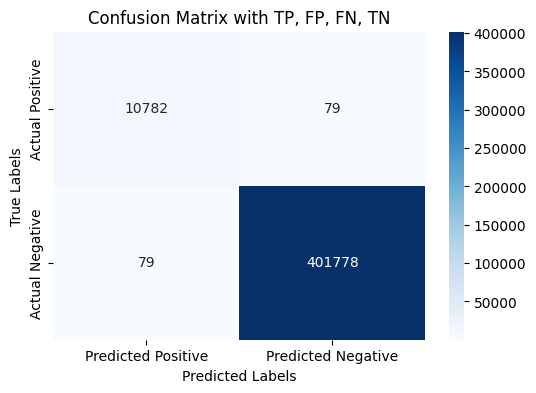

In [22]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the model definition function
def load_defined_model(model_name, num_classes, device):
    if model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise NotImplementedError("Model not implemented")
    model = model.to(device)
    return model, None

# Load data function
def load_data(resize, val_split=0.2):
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(resize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    data_dir = './plantvillage dataset/color'  # Replace with your data directory
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    return trainloader, valloader

# Load the saved model's state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'resnet34'
num_classes = 38
model_path = "trained_model.pth"

# Define and load the model
model, _ = load_defined_model(model_name, num_classes, device)
model.load_state_dict(torch.load(model_path))  # Load the saved weights
model.eval()  # Set model to evaluation mode
print(f"Model loaded from {model_path}")

# Load and transform the dataset
resize = 224
val_split = 0.2
_, val_loader = load_data(resize, val_split=val_split)
print(f"Validation data loaded with {len(val_loader.dataset)} samples.")

# Evaluate model and collect true and predicted labels
true_labels, pred_labels = [], []

print(f"Evaluating on {len(val_loader.dataset)} samples...")
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

print(f"Evaluation completed. Total samples evaluated: {len(true_labels)}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# For multiclass classification: Extract TP, FP, FN, TN for each class
TP = np.diagonal(cm)  # True Positives for each class (diagonal elements)
FP = cm.sum(axis=0) - TP  # False Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Print TP, TN, FP, FN for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  False Positives (FP): {FP[i]}")
    print(f"  False Negatives (FN): {FN[i]}")
    print(f"  True Negatives (TN): {TN[i]}")
    print('-' * 40)

# Create a matrix for TP, FP, FN, TN across all classes (sum)
detailed_cm = np.array([[TP.sum(), FP.sum()], [FN.sum(), TN.sum()]])

# Plot the confusion matrix as a heatmap without class labels
plt.figure(figsize=(6, 4))
sns.heatmap(
    detailed_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted Positive', 'Predicted Negative'],
    yticklabels=['Actual Positive', 'Actual Negative']
)
plt.title('Confusion Matrix with TP, FP, FN, TN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
